In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno
import pickle

# Apply Matplotlib style
plt.style.use('seaborn-v0_8')  # Use a valid style name; ensure Seaborn is installed

# Suppress warnings
warnings.filterwarnings('ignore')

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [11]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [12]:
data = pd.concat([train,test]).reset_index(drop=True)
cols_cat = data.select_dtypes('object').columns # To be explained later
cols_numeric = data._get_numeric_data().columns # To be explained later

In [13]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [14]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [15]:
print(data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

<Axes: >

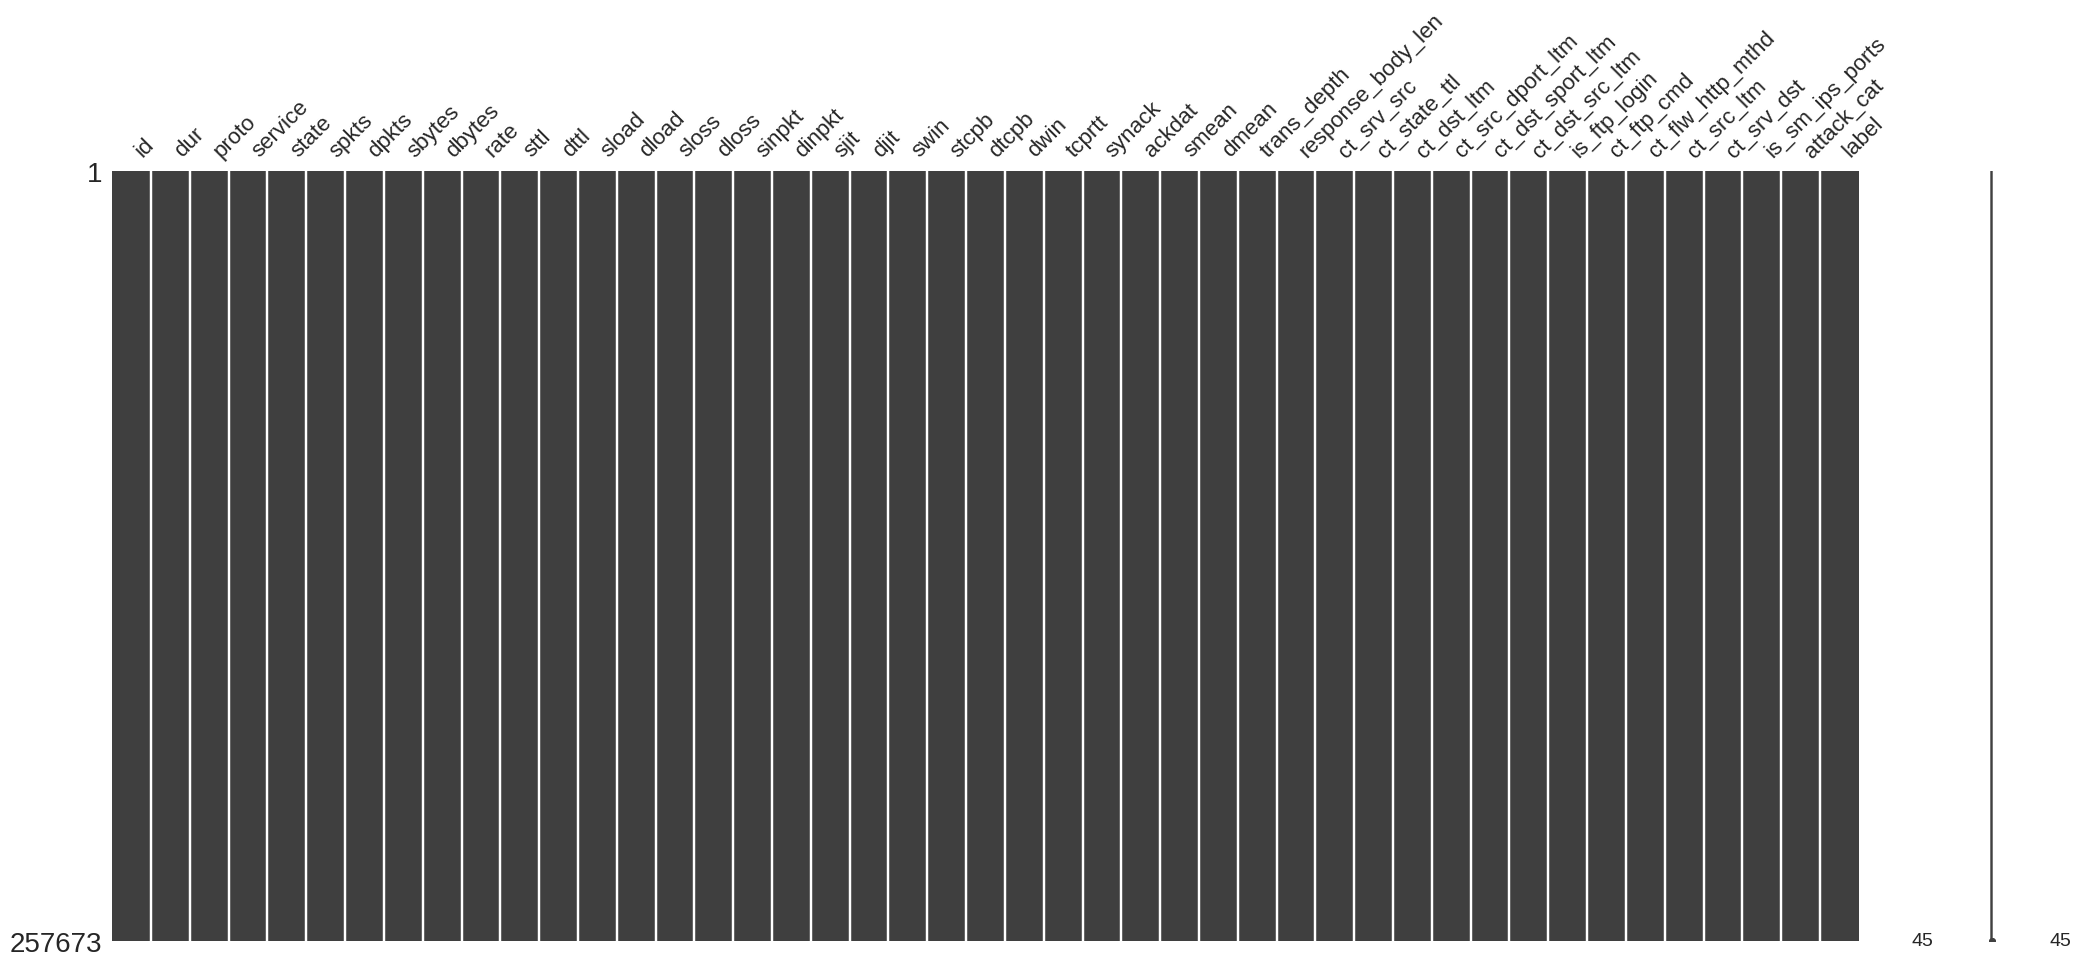

In [16]:
missingno.matrix(data)

In [17]:
data['proto'].unique() #This is definitely a categorical feature.

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


In [18]:
data['service'].unique() #Here, we'll deal with the type of service that is '-'
data['service']= np.where(data['service'] == '-', 'None', data['service'])
print(data['service'].unique())

['None' 'http' 'ftp' 'ftp-data' 'smtp' 'pop3' 'dns' 'snmp' 'ssl' 'dhcp'
 'irc' 'radius' 'ssh']


In [19]:
data['state'].unique() #Keep it

array(['INT', 'FIN', 'REQ', 'ACC', 'CON', 'RST', 'CLO', 'ECO', 'PAR',
       'URN', 'no'], dtype=object)

In [20]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [21]:
cols = data.columns
data_bin = Remove_dump_values(data, cols)

In [22]:
data_bin = data_bin.drop(['id'], axis=1) #Remove Unnecessary features

In [23]:
data_bin.drop(['attack_cat'], axis=1, inplace=True)

In [24]:
cols_cat = cols_cat.drop(['attack_cat'])

In [25]:
data_bin_hot = pd.get_dummies(data_bin,columns=cols_cat)

In [26]:
data_bin_hot.shape

(257673, 197)

In [27]:
cols_numeric = list(cols_numeric)
cols_numeric.remove('label')
cols_numeric.remove('id')

In [28]:
data_bin_hot[cols_numeric] = data_bin_hot[cols_numeric].astype('float')

In [29]:
data_bin_hot[cols_numeric] = (data_bin_hot[cols_numeric] - np.min(data_bin_hot[cols_numeric])) / np.std(data_bin_hot[cols_numeric])

In [30]:
data_bin_hot.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,1.841222e-06,0.014712,0.0,0.002854,0.0,0.566962,2.478337,0.0,0.971102,0.0,...,False,False,False,False,True,False,False,False,False,False
1,1.339070e-06,0.014712,0.0,0.010140,0.0,0.779572,2.478337,0.0,4.743422,0.0,...,False,False,False,False,True,False,False,False,False,False
2,8.369190e-07,0.014712,0.0,0.006146,0.0,1.247316,2.478337,0.0,4.600204,0.0,...,False,False,False,False,True,False,False,False,False,False
3,1.004303e-06,0.014712,0.0,0.005179,0.0,1.039430,2.478337,0.0,3.230480,0.0,...,False,False,False,False,True,False,False,False,False,False
4,1.673838e-06,0.014712,0.0,0.012234,0.0,0.623658,2.478337,0.0,4.578667,0.0,...,False,False,False,False,True,False,False,False,False,False


In [32]:
from sklearn import model_selection
from sklearn import metrics
X = data_bin_hot.drop('label', axis=1)
Y = data_bin_hot['label']

In [33]:
global X #To include in upcoming functions.

In [34]:
def fit_algo(algo, x, y, cv):
    #Fit the model
    model = algo.fit(x, y)

    #Check its score
    acc = round(model.score(x, y) *100, 2)
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv, n_jobs = -1)

    acc_cv = round(metrics.accuracy_score(Y,y_pred)*100, 2)

    return y_pred, acc, acc_cv, model

In [35]:
from sklearn.svm import LinearSVC
start_time = time.time()

pred_now, acc_svc, acc_cv_svc, svc= fit_algo(LinearSVC()
                                        ,X,Y,10)

svc_time = (time.time() - start_time)

print("Accuracy: %s" % acc_svc)
print("Accuracy of CV: %s" % acc_cv_svc)
print("Execution time: %s" % svc_time)

Accuracy: 90.24
Accuracy of CV: 89.12
Execution time: 256.00915265083313
